## Using Tensorflow to implement Logistic Regression model

In [1]:
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris

 **Step 1: Read the data**

In [3]:
iris_dict = load_iris()

In [4]:
iris = pd.concat([pd.DataFrame(iris_dict['data'], columns=['SepalLengthCm', 'SepalWidthCm','PetalLengtCm','PetalWidthCm']),
                 pd.Series(iris_dict['target'], name='Species')], axis=1)

In [5]:
iris.head()

SepalLengthCm  SepalWidthCm  PetalLengtCm  PetalWidthCm  Species
0            5.1           3.5           1.4           0.2        0
1            4.9           3.0           1.4           0.2        0
2            4.7           3.2           1.3           0.2        0
3            4.6           3.1           1.5           0.2        0
4            5.0           3.6           1.4           0.2        0

I want to do a binary classification, so keep the first 100 rows of data

Iris-setosa species is linearly separable from the other two, but the other two are not linearly separable from each other.To keep the species blance
Iris-setosa and Iris-versicolor are choosen

In [6]:
iris = iris[:100]

In [7]:
iris.shape

(100, 5)

**Step 2:  Numerical processing**

* replace 'Iris-setosa' as 0
* replace 'Iris-versicolor' as 1

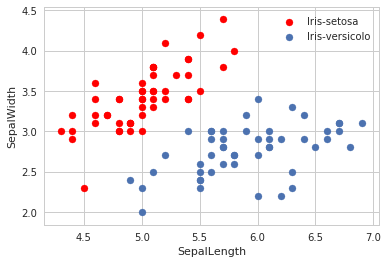

In [8]:
plt.scatter(iris[:50].SepalLengthCm, iris[:50].SepalWidthCm, label='Iris-setosa', c='r')
plt.scatter(iris[51:].SepalLengthCm, iris[51:].SepalWidthCm, label='Iris-versicolo')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')

In [9]:
X = iris.drop(labels=['Species'], axis=1).values
y = iris.Species.values

**Step 3: Split data** 

* trainset: 80%
* testset: 20%

In [10]:
# set seed for numpy and tensorflow
# set for reproducible results
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

In [11]:
# set replace=False, Avoid double sampling
train_index = np.random.choice(len(X), round(len(X) * 0.8), replace=False)

In [12]:
# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

In [13]:
# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

**Step 4: Normalized processing**

In [14]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
train_X = min_max_normalized(train_X)
test_X = min_max_normalized(test_X)

**Step 5: Build the model framework**


* You are going to compute your own logistic regression
* First you need to define your variables


* Declare the variables that need to be learned and initialization
* There are 4 features here, A's dimension is (4, 1)

cf : https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer

In [26]:
A = tf.Variable(tf.random_normal(shape=[4, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#### Define placeholders

In [27]:
data = tf.placeholder(tf.float32, shape=(None, 4))
target = tf.placeholder(tf.float32, shape=(None, 1))

#### Define your model

In [28]:
mod = tf.matmul(data, A) + b

#### Declare loss function, Use the sigmoid cross-entropy loss function

cf : https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits


In [29]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=mod))

In [30]:
# Define the learning rate， batch_size etc.
learning_rate = 0.003
batch_size = 20
iter_num = 300

#### Define the optimizer you want to use to minimize your loss fonction

cf : https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer

In [31]:
opt = tf.train.GradientDescentOptimizer(learning_rate)

#### You want to minize your loss function so use declare it to your optimizer you just defined

In [32]:
goal = opt.minimize(loss)

#### We define the accuracy to see if our model performs well.

In [33]:
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

**Step 6: Model training**

In [35]:
# training model
loss_trace = []
train_acc = []
test_acc = []

for epoch in range(iter_num):
    # Generate random batch index
    for i in range(4):
        batch_index = range(i*batch_size,(i+1)*batch_size-1)
        batch_train_X = train_X[batch_index]
        batch_train_y = np.matrix(train_y[batch_index]).T
        # run the session to train your regression
        sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
        # compute the loss on batch_train_X in temp_loss
        temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})    
    #compute accuracy on train and test
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 20 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:   20 loss: 0.652918 train_acc: 0.762500 test_acc: 0.550000
epoch:   40 loss: 0.640819 train_acc: 0.900000 test_acc: 0.800000
epoch:   60 loss: 0.629262 train_acc: 0.975000 test_acc: 0.950000
epoch:   80 loss: 0.618176 train_acc: 1.000000 test_acc: 0.950000
epoch:  100 loss: 0.607506 train_acc: 1.000000 test_acc: 1.000000
epoch:  120 loss: 0.597205 train_acc: 1.000000 test_acc: 1.000000
epoch:  140 loss: 0.587237 train_acc: 1.000000 test_acc: 1.000000
epoch:  160 loss: 0.577573 train_acc: 1.000000 test_acc: 1.000000
epoch:  180 loss: 0.568190 train_acc: 1.000000 test_acc: 1.000000
epoch:  200 loss: 0.559067 train_acc: 1.000000 test_acc: 1.000000
epoch:  220 loss: 0.550189 train_acc: 1.000000 test_acc: 1.000000
epoch:  240 loss: 0.541543 train_acc: 1.000000 test_acc: 1.000000
epoch:  260 loss: 0.533117 train_acc: 1.000000 test_acc: 1.000000
epoch:  280 loss: 0.524901 train_acc: 1.000000 test_acc: 1.000000
epoch:  300 loss: 0.516887 train_acc: 1.000000 test_acc: 1.000000


**Step 7: Visualization**

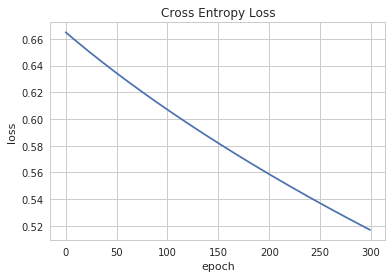

In [36]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

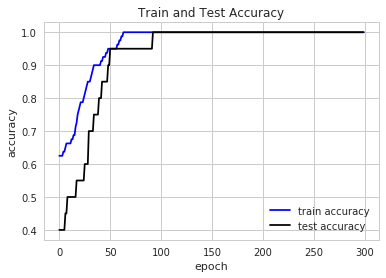

In [37]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

### Bonus : change the optimizer and the learning and see the results